In [1]:
from numpy import linalg as LA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random as rd
from sympy import Plane, Point3D
from scipy import interpolate
import random
import pandas as pd
import cmath
import networkx as nx

### Maki-Thompson rede estatica

$S + I \xrightarrow{\lambda}  S + S$


$S + S \xrightarrow{\alpha} R + S$


$S + R \xrightarrow{\alpha} R + R$

ignorant (I), spreaders (S) and stifler (R)

In [21]:
def find(v, i): # function to find the positions of element i in vector v
    l = []
    pos = 0
#     for x in v:
    for k in range(len(v)):
        if(v[k] == i):
            l.append(pos)
        pos = pos + 1
    return l

def Maki_thompson(G, beta=0.3, alpha=1, vector_states = list()):
#     print(vector_states)
    N = G.number_of_nodes()
    ignorant = find(vector_states,0) 
    stifler = find(vector_states,1)
    spreader = find(vector_states,2)
    for i in ignorant: 
        neigs = G.neighbors(i)
        for j in neigs:
            if vector_states[j] == 2:
                if np.random.rand() < alpha:
                    vector_states[i] = 2
                else: pass
    for i in spreader: 
        neigs = G.neighbors(i)
        for j in neigs:
            if vector_states[j] == 2:
                if np.random.rand() < alpha:
                    vector_states[j] = 1
                else: pass
    for i in stifler: 
        neigs = G.neighbors(i)
        for j in neigs:
            if vector_states[j] == 2:
                if np.random.rand() < alpha:
                    vector_states[j] = 2
                else: pass
    return vector_states

### Surface

In [3]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# embedding of covariance function on a [0,R]^2 grid
def rho(x,y,R,alpha):

    if alpha <= 1.5:
        # alpha=2*H, where H is the Hurst parameter
        beta = 0
        c2 = alpha/2
        c0 = 1-alpha/2
    else:
        # parameters ensure piecewise function twice differentiable
        beta = alpha*(2-alpha)/(3*R*(R**2-1))
        c2 = (alpha-beta*(R-1)**2*(R+2))/2
        c0 = beta*(R-1)**3+1-c2

    # create continuous isotropic function
    r = np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)
    if r<=1:
        out=c0-r**alpha+c2*r**2
    elif r<=R:
        out=beta*(R-r)**3/r
    else:
        out=0

    return out, c0, c2

# The main control is the Hurst parameter: H should be between 0 and
# 1, where 0 is very noisy, and 1 is smoother.
def brownian_surface(N=100, H=0.5):
    R = 2  # [0,R]^2 grid, may have to extract only [0,R/2]^2

    # size of grid is m*n; covariance matrix is m^2*n^2
    M = N

    # create grid for field
    tx = np.linspace(0, R, M)
    ty = np.linspace(0, R, N)
    rows = np.zeros((M,N))


    for i in range(N):
        for j in range(M):
            # rows of blocks of cov matrix
            rows[j,i] = rho([tx[i],ty[j]],
                            [tx[0],ty[0]],
                            R, 2*H)[0]

    BlkCirc_row = np.vstack(
        [np.hstack([rows, rows[:,-1:1:-1]]),
         np.hstack([rows[-1:1:-1,:], rows[-1:1:-1, -1:1:-1]])])

    # compute eigen-values
    lam = np.real(np.fft.fft2(BlkCirc_row))/(4*(M-1)*(N-1))
    lam = np.sqrt(lam)

    # generate field with covariance given by block circular matrix
    Z = np.vectorize(complex)(np.random.randn(2*(M-1), 2*(M-1)),
                              np.random.randn(2*(M-1), 2*(M-1)))
    F = np.fft.fft2(lam*Z)
    F = F[:M, :N] # extract sub-block with desired covariance

    out,c0,c2 = rho([0,0],[0,0],R,2*H)

    field1 = np.real(F) # two independent fields
    field1 = field1 - field1[0,0] # set field zero at origin

    # make correction for embedding with a term c2*r^2
    field1 = field1 + np.kron(np.array([ty]).T * np.random.randn(),
                              np.array([tx]) * np.random.randn())*np.sqrt(2*c2)
    X,Y = np.meshgrid(tx,ty)

    field1 = field1[:N//2, :M//2]

    return field1

In [4]:
def calc_thetas(field,D):
    normal_unit = []
    vector_normal = []
    for i in range(0,len(field)):
        data = [np.linspace(0,D,field.shape[1]),np.linspace(0,D,field.shape[1]),field[i]]
        data = np.transpose(data)
        gradiente = np.gradient(data)[1]
        #Normal precisa pegar a coordenada x e z (-partial(x), 1, -partial(z))
        gradient_x = gradiente[:,0]
        gradient_y = gradiente[:,1]
        gradient_z = gradiente[:,2]
        #normal = [-gradient_x, np.ones(len(gradient_z)), -gradient_z] #normal ao plano que ele se move
        normal = [gradient_x, gradient_y, -np.ones(len(gradient_x))]
        vector_normal.append(np.transpose(normal))
        #gradiente_real = [gradient_x,gradient_y,gradient_z]
    for k in range(0,len(normal)):
        normal_unit.append(vector_normal[k]/LA.norm(vector_normal[k]))

    for i in range(0,len(normal_unit)):
        abs_normal = abs(normal_unit[i])
        abs_gradiente = abs(gradiente[i])
    theta = abs((np.dot(normal_unit,np.transpose(gradiente))))/(np.dot(abs_normal, (abs_gradiente)))  
    return (theta[0])

### Agents

In [5]:
class Agent:
    def __init__(self, i, posx, posy, v, raio, campoz, thetas, p_recuperar, D, estado):
        self.indice = i
        self.vx = v
        self.vy = v
        self.v = v
        self.D = D
        self.nome="Pessoa "+str(i)
        self.campox = list(np.linspace(0,D,campoz.shape[0]))
        self.campoy = list(np.linspace(0,D,campoz.shape[0]))
        self.campoz = list(campoz)
        self.thetas = thetas
        
        self.indx_posx = self.campox.index(posx)
        self.indx_posy = self.campoy.index(posy)
        self.posx = self.campox[self.indx_posx]
        self.posy = self.campoy[self.indx_posy]
        self.posz = campoz[self.indx_posx][self.indx_posy]

        self.i_contagio = -1
        self.infectado = False
        self.suscetivel = True

        self.p_recuperar = p_recuperar
        self.raio = raio

        self.estado = estado

    def find_nearest(self, array, value):
        if np.asarray(array) is array:
            pass
        else:
            array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

    def infectar(self,i):
        #infect
        self.infectado=True
        self.suscetivel=False
        self.i_contagio=i

    def susceptible(self):
        #Susceptible again
        self.suscetivel=True
        self.infectado=False

    def check_contagio(self,i):
        if self.i_contagio>-1:
            if self.p_recuperar > np.random.uniform(0,1):
                  self.susceptible()
        else: pass

    def position(self):
        indx_posx = self.campox.index(self.posx)
        indx_posy = self.campoy.index(self.posy)
        theta = self.thetas[indx_posx][indx_posy]
        x = indx_posx
        y = indx_posy
        N = len(self.campoz)
        baixo = self.campoz[(x+int(self.v*theta))%N][y]
        direita = self.campoz[x][(y+int(self.v*theta))%N]
        cima = self.campoz[(x-int(self.v*theta))%N][y]
        esquerda = self.campoz[x][(y-int(self.v*theta))%N]

        if theta < 0:
            z = max(baixo,direita,cima,esquerda)
        elif theta == 0:
            z = np.random.choice(baixo,direita,cima,esquerda)
        else:
            z = min(baixo,direita,cima,esquerda)
        x,y = np.where(self.campoz == z)
        self.indx_posx = x[0]
        self.indx_posy = y[0]

        self.posz = self.campoz[self.indx_posx][self.indx_posy]
        self.posx = self.campox[self.indx_posx]
        self.posy = self.campoy[self.indx_posy]

    def get_pos(self):
        self.posz = self.campoz[self.indx_posx][self.indx_posy]
        self.posx = self.campox[self.indx_posx]
        self.posy = self.campoy[self.indx_posy]
        return (self.posx, self.posy, self.posz)
    def get_index(self):
        return (self.indx_posx, self.indx_posy)

    def get_dist(self,x,y,z): 
        return np.sqrt((self.posx-x)**2+(self.posy-y)**2+(self.posz-z)**2)

### Com intervençao da rede estatica

In [38]:
def run_simulation_multicamadas(frame, tempo,p_contagio,n, G, beta, alpha,vector_states, prob):
    proximos = {}
    indices = {}
    dici = {}
    n_recuperados = 0
    n_infectados = 0
    estados = Maki_thompson(G, beta, alpha, vector_states)

    for p in pessoas:
        p.check_contagio(frame)
        p.position()
        p.estados = estados[p.indice]
        if p.infectado == True:
            n_infectados += 1
            for per in pessoas:
                if per.indice == p.indice or per.infectado == True:
                        pass
                else:
                    per.get_pos()
                    d = p.get_dist(per.posx,per.posy,per.posz)
                    if d < p.raio:
                        if per.estado == 2:
                            if prob <= np.random.random():
#                                 p.v = -p.v
                                x = random.choice(random.choice(p.campoz))
                                p.posx,p.posy = (np.where(p.campoz == x))
                            else: pass
                        else: 
                            if rd.uniform(0,1) < p_contagio:
                                per.infectar(frame)
                            else: pass
                    else: pass
        proximos[p.indice] = (p.get_pos())
        indices[p.indice] = p.get_index()
    tempo.append(frame)
    infectados[frame] = (n_infectados*100/n)
    return infectados, estados

### Sem intervenção

In [19]:
def run(hurst, n_agentes, v, inter, p_contagio, p_recuperar, n_contaminados,
        raio, N_malha, D, prob):
    
    
    av_degree = 20 # average degree
    p = float(av_degree)/float(n_agentes) #probability of connection in the ER model
    m = int(av_degree/2) # number of nodes included at each time step in the BA model
    kappa = av_degree # number of neighbors in the WS model

    G = nx.barabasi_albert_graph(n_agentes,m) # generate a BA network
    # function to simulate the SIR dynamics starting from a single seed node
    vector_states = np.zeros(n_agentes) # vector that stores the states of the vertices
    spread = 5
    for i in range(n_agentes):
        if np.random.random() <= spread/100:
            vector_states[i] = 2
    # Epidemic parameters
    beta = 0.5 # Probability of infection
    alpha = 0.5  # Probability of recovering
    seed = 0
#     vetor_estados = Maki_thompson(G, beta, alpha, vector_states)


    field1 = brownian_surface(N_malha, H = hurst)

    posicoes = {}
    
    X1, Y1 = np.meshgrid(np.linspace(0,D,field1.shape[0]),
                                   np.linspace(0,D,field1.shape[1]))
    Z = field1
    theta = calc_thetas(Z,D)

    contaminados = 0
    global pessoas

    pessoas = []

    possiveis_posicoes = np.linspace(0,D,field1.shape[1])
    posicao_x = []
    posicao_y = []


    for i in range(n_agentes): #Desse jeito os agentes nao começam fora da superficie
        x = random.choice(random.choice(field1))
        x_pos,y_pos = (np.where(field1 == x))
        posicao_x.append(possiveis_posicoes[x_pos])
        posicao_y.append(possiveis_posicoes[y_pos])

    nao_aguento_mais = {}
    for i in range(n_agentes):
        p = Agent(i,posicao_x[i],posicao_y[i], v, raio, field1, theta, p_recuperar,D,vector_states[i] )
        nao_aguento_mais[p.indice] = (p.posx,p.posy,p.posz)
        if np.random.uniform(0,1) < n_contaminados/100:
            p.infectar(0)
            contaminados += 1
        pessoas.append(p)


    posicaox = []
    posicaoy = []
    posicaoz = []
    global recuperados, infectados
    recuperados = {}
    infectados = {}
    tempo = [0]

    k = []
    estados_anteriores = []
    estados_anteriores.append(vector_states)
    for i in range(1,inter):
        if i == 1:
            N_infected_multicamadas, estados = run_simulation_multicamadas(i,tempo,p_contagio,n_agentes,
                                                                     G, beta, alpha,estados_anteriores[i-1], prob)
            k.append(N_infected_multicamadas)
            estados_anteriores.append(estados)
        else: 
            N_infected_multicamadas, estados = run_simulation_multicamadas(i,tempo,p_contagio,n_agentes,
                                                                     G, beta, alpha,estados_anteriores[i-1], prob)
            k.append(N_infected_multicamadas)
            estados_anteriores.append(estados)
    return k

Concluido: % 1.0
Concluido: % 2.0
Concluido: % 3.0
Concluido: % 4.0
Concluido: % 5.0
Concluido: % 6.0
Concluido: % 7.0
Concluido: % 8.0
Concluido: % 9.0
Concluido: % 10.0
Concluido: % 11.0
Concluido: % 12.0
Concluido: % 13.0
Concluido: % 14.0
Concluido: % 15.0
Concluido: % 16.0
Concluido: % 17.0
Concluido: % 18.0
Concluido: % 19.0
Concluido: % 20.0
Concluido: % 21.0
Concluido: % 22.0
Concluido: % 23.0
Concluido: % 24.0
Concluido: % 25.0
Concluido: % 26.0
Concluido: % 27.0
Concluido: % 28.0
Concluido: % 29.0
Concluido: % 30.0
Concluido: % 31.0
Concluido: % 32.0
Concluido: % 33.0
Concluido: % 34.0
Concluido: % 35.0
Concluido: % 36.0
Concluido: % 37.0
Concluido: % 38.0
Concluido: % 39.0
Concluido: % 40.0
Concluido: % 41.0
Concluido: % 42.0
Concluido: % 43.0
Concluido: % 44.0
Concluido: % 45.0
Concluido: % 46.0
Concluido: % 47.0
Concluido: % 48.0
Concluido: % 49.0
Concluido: % 50.0
Concluido: % 51.0
Concluido: % 52.0
Concluido: % 53.0
Concluido: % 54.0
Concluido: % 55.0
Concluido: % 56.0
C

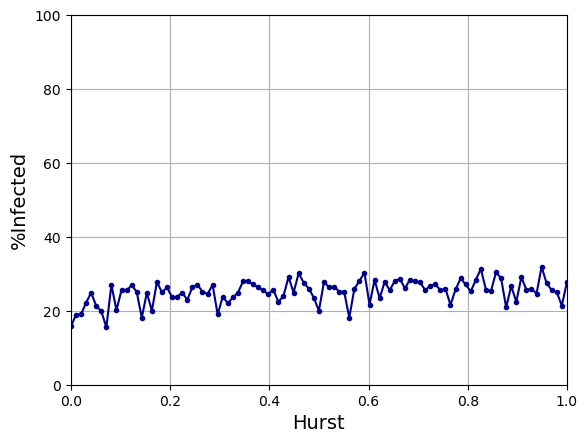

In [40]:
lista2 = {}
for i in range(1,100):
    medias = []
    hurst = 0.9
    prob = round(0.01*i,2)
    for j in range(30):
        N_agentes = 100 #number of nodes
        passos = 25
        D = np.sqrt(N_agentes)
        r = 0.5
        raio = hurst*r*D/10
       
        k = run(hurst = hurst, n_agentes = N_agentes, v = 1, inter = passos, p_contagio = 1,
                p_recuperar = 0.5, n_contaminados = 20, raio = raio, N_malha = 100,
                D = D, prob = prob)
        medias.append(k[len(k)-1][len(k)-1])
    lista2[prob] = np.mean(medias)
    print("Concluido:", "%",round(prob*100,1))

plt.plot(np.linspace(0,1,len(lista2)), list(lista2.values()),".-",color = "darkblue")
plt.grid()
plt.ylim(0,100)
plt.xlim(0,1)
plt.xlabel("Hurst", fontsize = 14)
plt.ylabel("%Infected", fontsize = 14)
plt.show()

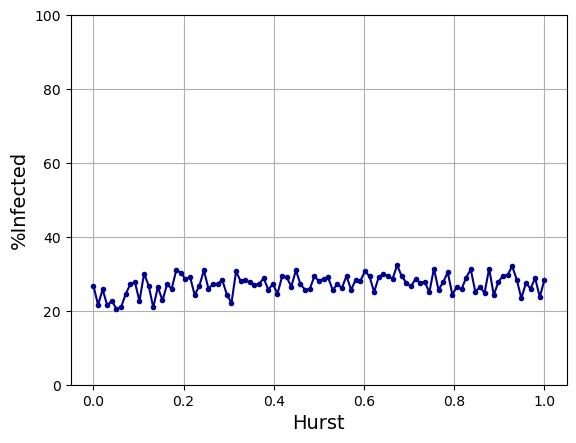

In [36]:
plt.plot(np.linspace(0,1,len(lista2)), list(lista2.values()),".-",color = "darkblue")
plt.grid()
plt.ylim(0,100)
# plt.xlim(0,1)
plt.xlabel("Hurst", fontsize = 14)
plt.ylabel("%Infected", fontsize = 14)
plt.show()

In [13]:
lista = []
for i in range(1,100):
    medias = []
    t = round(0.01*i,2)
    for j in range(100):
        N_agentes = 100 #number of nodes
        av_degree = 5 # average degree
        p = float(av_degree)/float(N_agentes) #probability of connection in the ER model
        m = int(av_degree/2) # number of nodes included at each time step in the BA model
        kappa = av_degree # number of neighbors in the WS model

        G = nx.barabasi_albert_graph(N_agentes,m) # generate a BA network

        # Epidemic parameters
        beta = 1 # Probability of infection
        alpha = j*0.01  # Probability of recovering
        passos = 20
        estados = Maki_thompson(G, beta, alpha, inter = passos)
        average = []
        for x in range(10):
            N_malha = N_agentes
            d = np.sqrt(N_agentes)
            field1 = brownian_surface(N_malha, t)

            v = 1
            p_contagio = 1
            p_recuperar = 0.5
            n_contaminados = 10
            raio = t*0.5*d/10
            p_salto = 0
            camadas = True

            k = run(t,N_agentes, v , passos, p_contagio,
                p_recuperar, n_contaminados, raio, N_malha, d, 
                estados, field1, camadas, p_salto)
            average.append(k[len(k)-1][len(k)-1])
        medias.append(np.mean(average))
    lista.append(medias)
    print("Concluido:", "%",round(t*100,1))

Concluido: % 1.0
Concluido: % 2.0
Concluido: % 3.0
Concluido: % 4.0
Concluido: % 5.0
Concluido: % 6.0
Concluido: % 7.0
Concluido: % 8.0
Concluido: % 9.0
Concluido: % 10.0
Concluido: % 11.0
Concluido: % 12.0
Concluido: % 13.0
Concluido: % 14.0
Concluido: % 15.0
Concluido: % 16.0
Concluido: % 17.0
Concluido: % 18.0
Concluido: % 19.0
Concluido: % 20.0
Concluido: % 21.0
Concluido: % 22.0
Concluido: % 23.0
Concluido: % 24.0
Concluido: % 25.0
Concluido: % 26.0
Concluido: % 27.0
Concluido: % 28.0
Concluido: % 29.0
Concluido: % 30.0
Concluido: % 31.0
Concluido: % 32.0
Concluido: % 33.0
Concluido: % 34.0
Concluido: % 35.0
Concluido: % 36.0
Concluido: % 37.0
Concluido: % 38.0
Concluido: % 39.0
Concluido: % 40.0
Concluido: % 41.0
Concluido: % 42.0
Concluido: % 43.0
Concluido: % 44.0
Concluido: % 45.0
Concluido: % 46.0
Concluido: % 47.0
Concluido: % 48.0
Concluido: % 49.0
Concluido: % 50.0
Concluido: % 51.0
Concluido: % 52.0
Concluido: % 53.0
Concluido: % 54.0
Concluido: % 55.0
Concluido: % 56.0
C

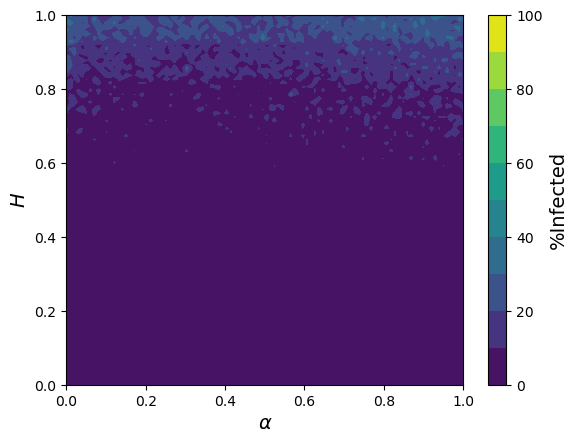

In [17]:
hurst = np.linspace(0,1,len(lista))
density = np.linspace(0,1,len(lista[0]))
levels = np.arange(0,110,10)
CS = plt.contourf(density,hurst,lista,levels) 
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel("%Infected", fontsize = 14)
plt.xlabel(r"$\alpha$", fontsize = 14)
plt.ylabel('$H$', fontsize = 14)
# plt.savefig('teste.png', dpi = 150, bbox_inches = 'tight')
plt.show()

In [ ]:
# lista1000 = []
# m = list(lista.values())
# for i in range(0,len(lista)):
#     lista1000.append(m[i])

# # convert array into dataframe

# DF2 = pd.DataFrame(lista1000)
 
# # save the dataframe as a csv file
# DF2.to_csv("escala_multi_SIS_100.csv")

In [3]:
import numpy as np
import pandas as pd

mu, sigma = 0, 0.1 
k = np.random.normal(mu, sigma, 1000)

DF2 = pd.DataFrame(k)
 
# # save the dataframe as a csv file

DF2.to_csv("teste.csv")
